# Standard example of Lompe

This notebook is an example of how to use the Lompe technique to combine available measurements to get a complete 2D map of the electrodynamics in a local region (full explanation of the technique can be found in [Laundal et al. 2022](https://doi.org/10.1029/2022JA030356)). 

In this notebook we will:
- Set up a local grid that is offset from the north pole and rotated slightly
- Use the implemented conductance models to get ionospheric conductance
- Use ionospheric electric field as input data, $\mathbf{\tilde{y}}$
- Run the Lompe inversion to get the model amplitudes, $\mathbf{m}$ ($\mathbf{\tilde{y}}=\mathbb{G}\mathbf{m}$)
- Plot the Lompe output using *lompeplot*


For this example, we are using an electric field derived from an ionospheric electric potential $\Phi$ from the [Weimer (2005)](https://doi.org/10.1029/2004JA010884) model (see Notebook 01) as $\mathbf{\tilde{y}}$. The ionospheric conductance is the same as have in the example in Notebook 03.

More examples of the Lompe technique can be found in the /lompe_paper_figures/ folder.

Import relevant modules

In [1]:
%matplotlib inline
import lompe
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd
import apexpy
from scipy.interpolate import griddata
from scipy.ndimage import median_filter

Re = 6371.2e3    # Earth radius
HI = 110e3       # Ionospheric altitude
stencil_size = 1 # size of stencil for differentiation 

##### Cubed sphere grid
We set up cubed-sphere grid over a region of North America:

In [2]:
L, W, Lres, Wres = 7000e3, 5000e3, 100e3, 100e3 # m
position = (-88, 72) # geographic lon, lat of center of grid
orientation = 45     # angle defining orientation of xi-axis
projection = lompe.cs.CSprojection(position, orientation)
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R = Re+HI) # set grid to ionospheric altitude

We can plot coastlines and magnetic latitude circles under the grid to visualize which region it covers (the last figure in this notebook also shows the grid projection on an magnetic latitude, MLT coordinate system):

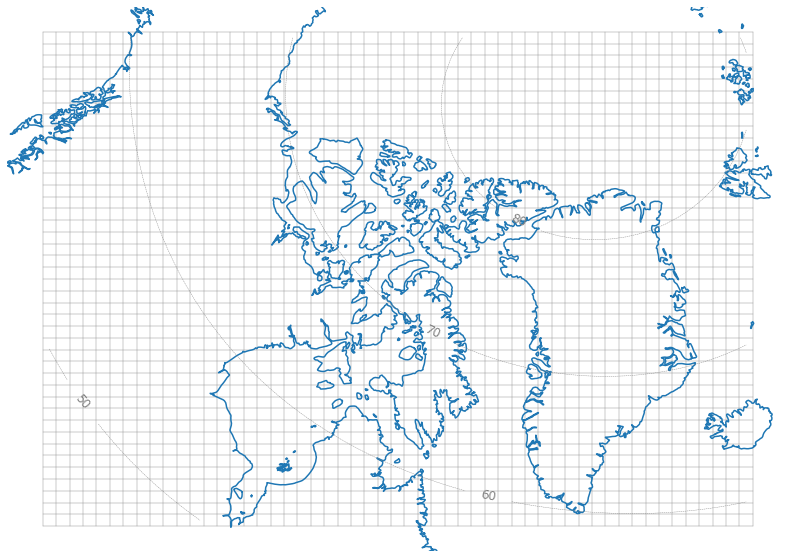

In [3]:
fig, ax = plt.subplots(figsize = (14, 10))
ax.set_axis_off()

# grid
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
# coastlines
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'C0')

# add (geographic) latitude contours
co = ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
ax.clabel(co, co.levels, inline = True, fontsize = 12)

ax.set_xlim(xlim)
ax.set_ylim(ylim);

##### Ionospheric conductances
The Lompe technique requires that the ionospheric conductances are defined across the entire grid. We use the implemented conductance models to get functions for the conductances (more details in Notebook 03).

In [4]:
time = dt.datetime(2005, 9, 10) # date is used for coordinate conversion and to get solar zenith angles (sza)
Kp   = 4                        # for Hardy model
F107 = 100                      # sfu, for EUV conductance
refh = 110                      # km, altitude for coodinate conversion

# functions for conductances to be passed to Lompe model
SH = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, time, 'hall')
SP = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, time, 'pedersen')

##### Input data - electric field
We get the electric field on our grid region from $\Phi$ by following the steps outlined in Notebook 01:

In [5]:
# read potential file:
weimer = pd.read_table('./datasets/weimer.txt', sep = ' ', skipinitialspace = True, 
                       comment = '#', names = ['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 0] # remove southern hemisphere

# get lat, lon coordinates, convert to SI-units
mlatxx = weimer.mlat.values.reshape((181, 61))
mltxx = weimer.mlt .values.reshape((181, 61))
V     = weimer.phi .values.reshape((181, 61)) * 1e3 # kV to V
# altitude of potenital values is approximately 110 km, same as grid

# convert from magnetic lat, local time coordinates to geographic lat, lon
a = apexpy.Apex(time, refh=110)
mlonxx = a.mlt2mlon(mltxx, time)
latxx, lonxx, _ = a.apex2geo(mlatxx, mlonxx, height=110)

# interpolate potential to grid 
xi, eta = grid.projection.geo2cube(lonxx, latxx)
V       = griddata((xi.flatten(), eta.flatten()), V.flatten(), (grid.xi.flatten(), grid.eta.flatten()), 
                   fill_value = 0, method = 'cubic').reshape(grid.shape)

# use cubed sphere differentiation matrices to get electric field (see notebook 01)
De, Dn = grid.get_Le_Ln(S = stencil_size, return_sparse = True)
E_e = -De.dot(V.flatten()).reshape(grid.shape)
E_n = -Dn.dot(V.flatten()).reshape(grid.shape)
E_tot = np.vstack((E_e.flatten(), E_n.flatten()))

We now have the data we want to use as input data $\mathbf{\tilde{y}}$ for Lompe. Before passing the data to Lompe, we need to make a Lompe Data object. This way we make sure that the data is on the correct format for Lompe, and that the correct equations are used to construct the SECS $\mathbb{G}$-matrices.

The electric field array os now of shape $(2,N)$, with rows corresponding to the two east and north dimensions of the $N$ data points. Note that we do not have any "up" components for the electric field, and we set the *components* keyword to $[0,1]$ (for *components*, 0, 1, 2 are indicies corresponding to east, north, up directions).
The coordinates of the data points are longitude and latitude of the $N$ data points and has shape $(2,N)$.
The electric field measurements in this example are in the range $\pm 44\ mV$, and the *scale* is set to $10^{-3}$. Note that we need to specify the data type.

In [6]:
components = [0,1]
coords = np.vstack((grid.lon.flatten(), grid.lat.flatten()))
scale = 10e-3
E_field_data = lompe.Data(E_tot, coords, datatype = 'efield', components=components, scale=scale)

##### Construct the Lompe model
Now, we can initialize a Lompe model object, add the input data, and run the inversion to get the model vector $\mathbf{m}$ that can be used to obtain other ionospheric parameters in the region:

In [7]:
# initialize model
model = lompe.Emodel(grid, Hall_Pedersen_conductance = (SH, SP))

# add input data
model.add_data(E_field_data)

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model.run_inversion(l1 = 0.01, l2 = 0.2);

##### Plot
The model predictions are most easily shown if we use *lompeplot*:

/Users/amalie/GitHub/lompe/secsy/secsy/utils.py:281: RuntimeWarning: invalid value encountered in true_divide
  ecef_t = ecef_t/np.linalg.norm(ecef_t, axis = 2)[:, :, np.newaxis] # normalize the result


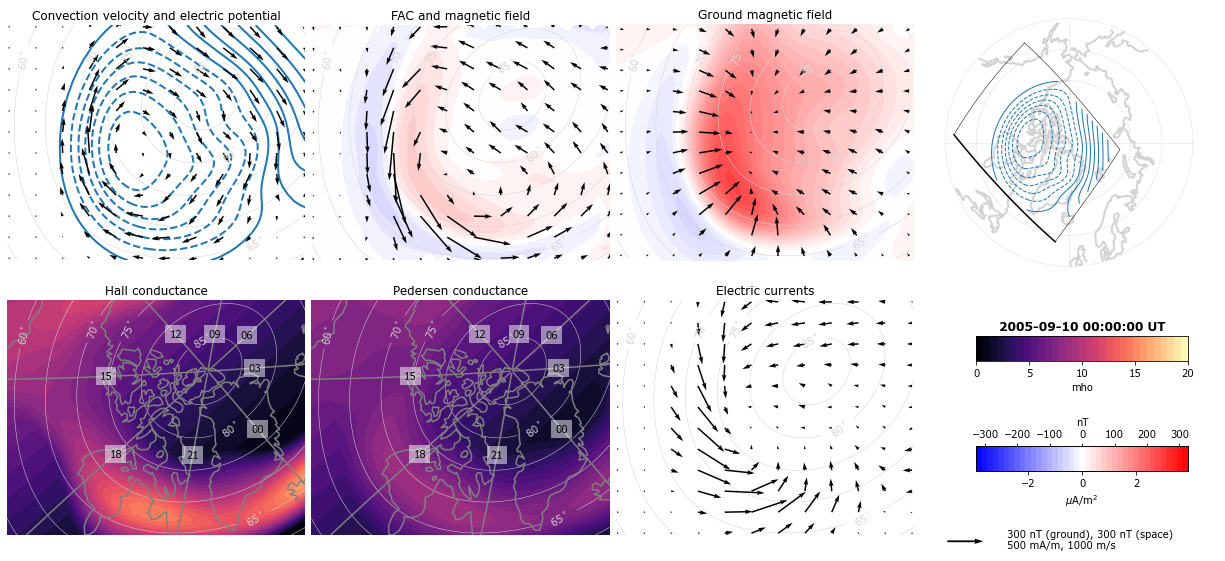

In [10]:
fig = lompe.lompeplot(model, include_data=False, time=time, apex=a, savekw = {'fname':'./output_figures/standardLompe.pdf'})
# also save png
fig.savefig('./output_figures/standardLompe.png')

The top row shows, from left to right: 
- Convection flow field and electric potential contours
- horizontal magnetic field disturbances 110 km above the ionosphere (grid altitude) as black arrows and radial current density as color contours
- horizontal ground magnetic field perturbations as black arrows and radial magnetic field perturbations as color contours
- a map that shows the grid’s position and orientation with respect to apex magnetic latitude and local time.

The bottom row shows, from left to right: 
- Pedersen conductance
- Hall conductance
- horizontal height-integrated ionospheric currents based on Lompe output
- color scale / vector scales

##### Access Lompe predictions for any location in analysis region

The Lompe model object has class methods for accessing individual ionospheric parameters from the model (after the inversion), meaning you do not need to be using *lompeplot* to show the data. Predictions for all parameters shown in the figure above can be accessed from the model object for any location within the grid region:
- Convection electric field (east, north)
- Electric potential (scalar)
- Convection velocity (east, north)
- Space magnetic field (east, north, up) - the height of the evaluation locations is by default twice the height of the ionosphere (grid)
- Space magnetic field due to FACs (east, north, up) - the height of the evaluation locations is the same as for spce magnetic field
- Ground magnetic field (east, north, up) - the height of the evaluation locations is by default the Earth's radius
- Horizontal ionospheric surface current density (east, north)
- Field-aligned current density (FAC) (scalar)

In [9]:
# locations we want the modelled ionspheric parameters in
lons, lats = np.array([0, 220]), np.array([90, 70])

# electric field
Emod = model.E(lon=lons, lat=lats)

# electric potential
Epotmod = model.E_pot(lon=lons, lat=lats)

# convection velocity
vmod = model.v(lon=lons, lat=lats)

# magnetic field in space
Bsmod = model.B_space(lon=lons, lat=lats, r=Re+2*HI)   

# space magnetic field due to FACs only
BsFACmod = model.B_space_FAC(lon=lons, lat=lats, r=Re+2*HI)     

# magnetic field on ground
Bgmod = model.B_ground(lon=lons, lat=lats, r=Re)

# horizontal electric current densities
jmod = model.j(lon=lons, lat=lats)

# FACs
FACmod = model.FAC(lon=lons, lat=lats)

If no locations are given, the default evaluation locations are used. For the convection electric field, electric potential, convection velocity, horizontal surface current densities and FACs, the centers of the interior grid points are the default locations. The magnetic field disturbances on ground and in space (both full and due to FACs) have default evaluation locations at the corner of the grid cells (intersects).